In [18]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch

In [ ]:
BATCH_SIZE = 5

image = cv2.imread("D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C8\C80001.png", 1)
images = [np.copy(image) for _ in range(BATCH_SIZE)]
ia.imshow(image)

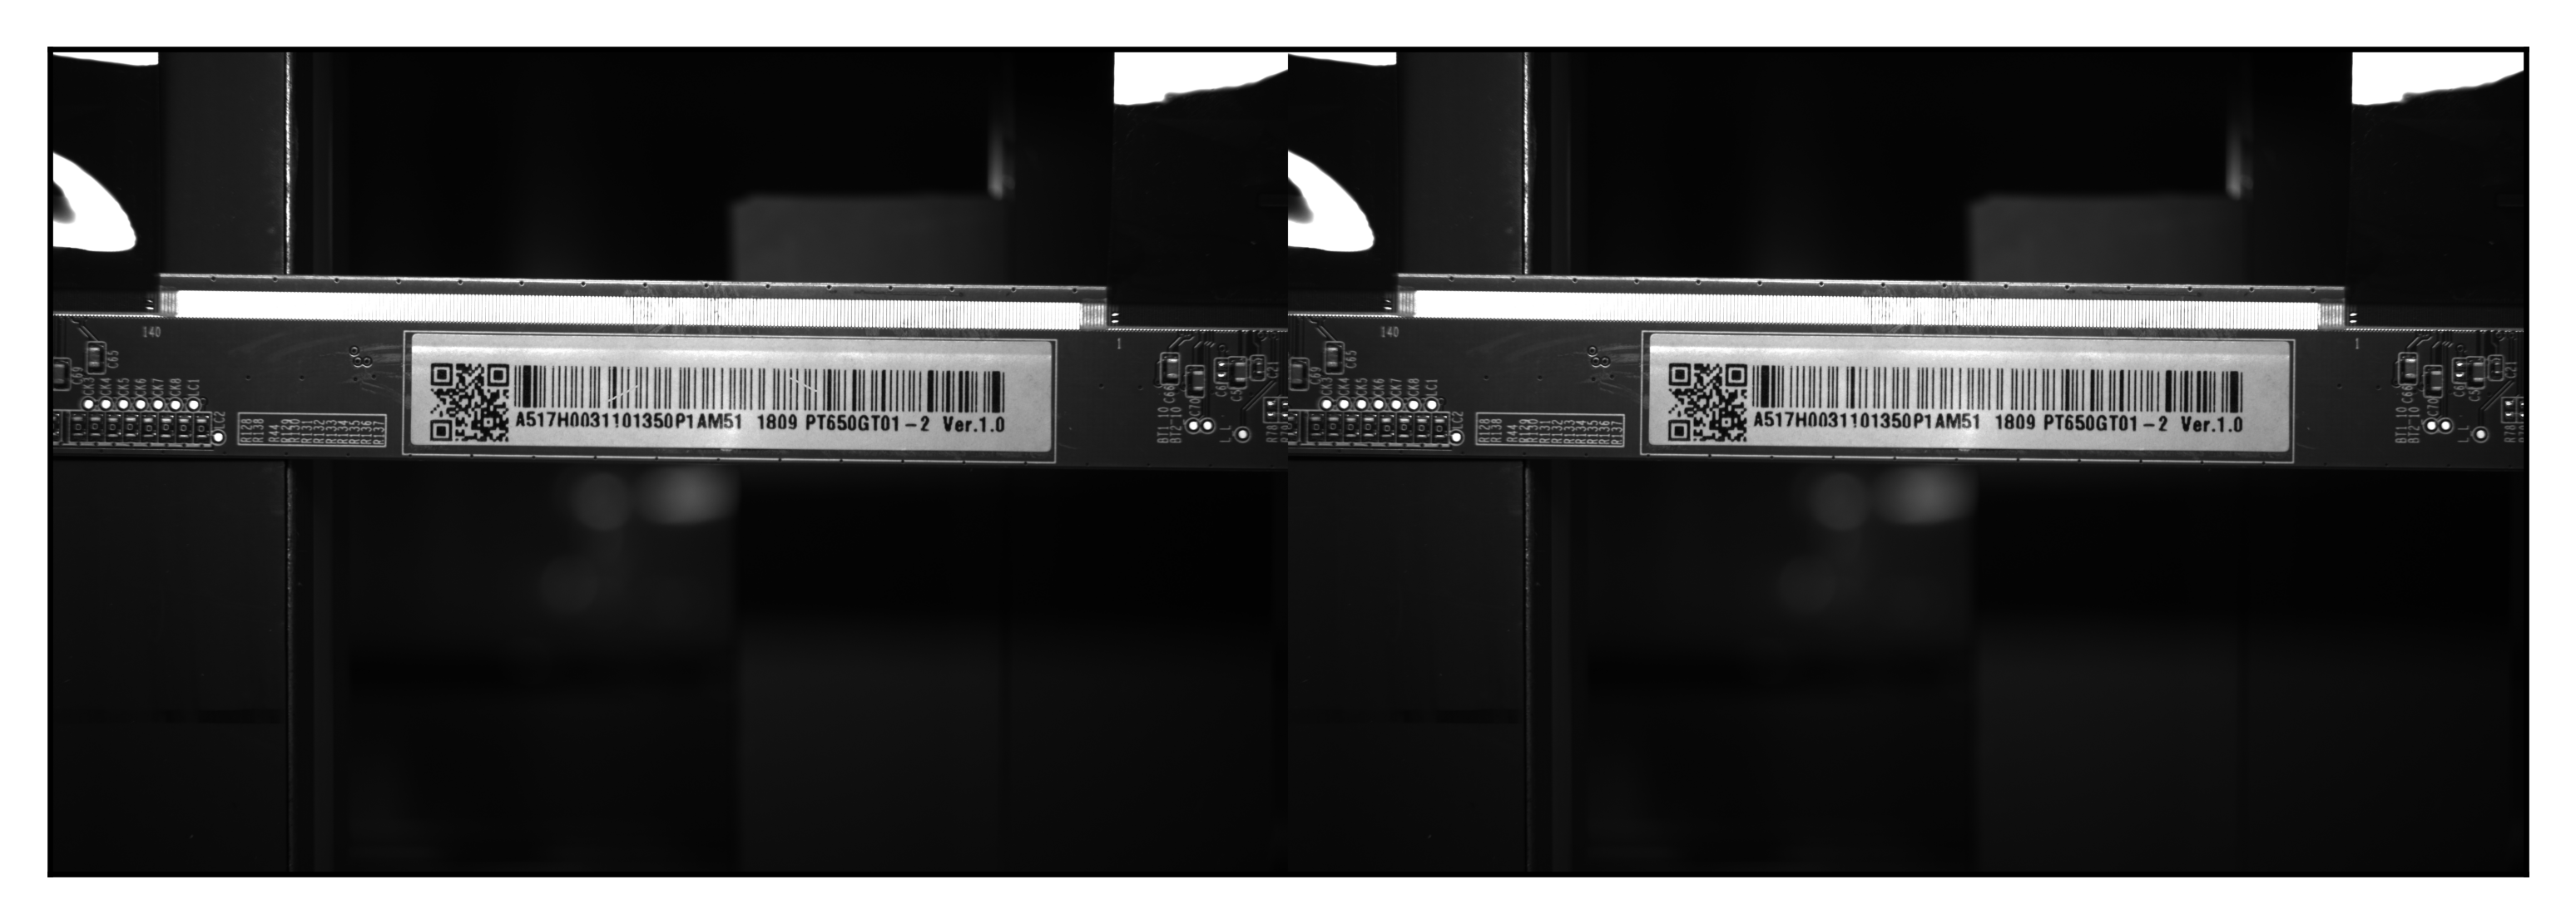

In [22]:
images_dir = r'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C9'
images = [cv2.imread(os.path.join(images_dir, filename), 1) for filename in os.listdir(images_dir)]
plt.figure(dpi=600)
plt.imshow(cv2.hconcat((images)))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
NB_BATCHES = 100
batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]

In [ ]:
seq = iaa.SomeOf([(1, None),
				  iaa.Fliplr(0.5),  # very fast
				  iaa.CropAndPad(px=(-10, 10)),  # very fast
				  iaa.Affine(rotate=(-25, 25)),
				  iaa.AdditiveGaussianNoise(scale=(10, 70)),
				  iaa.AdditiveLaplaceNoise(),
				  iaa.PiecewiseAffine(),
				  iaa.Crop(percent=(0, 0.2)),
				  iaa.AddToHueAndSaturation((-60, 60)),
				  iaa.Cutout(squared=False, fill_mode='gaussian'),
				  iaa.PerspectiveTransform(scale=(0.0, 0.1))
				  ], random_order=True)

In [ ]:
time_start = time.time()
batches_aug = list(seq.augment_batches(batches, background=False))  # background=True for multicore aug
time_end = time.time()

print("Augmentation done in %.2fs" % (time_end - time_start,))

for index, item in enumerate(batches_aug):
	for i, aug_img in enumerate(item.images_aug):
		cv2.imwrite(rf'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C8\batch{index}_image{i}.png', aug_img)


# ia.imshow(np.hstack(batches_aug[0].images_aug))


In [23]:
ia.seed(2022)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
		[
			iaa.Fliplr(0.2),  # horizontally flip 50% of all images
			iaa.Flipud(0.5),  # vertically flip 20% of all images

			sometimes(
					iaa.SomeOf(
							(1, None),
							[
								# crop some of the images by 0-10% of their height/width
								iaa.CropAndPad(percent=(0, 0.1)),
								# Apply affine transformations to some of the images
								# - scale to 80-120% of image height/width (each axis independently)
								# - translate by -20 to +20 relative to height/width (per axis)
								# - rotate by -45 to +45 degrees
								# - shear by -16 to +16 degrees
								# - order: use nearest neighbour or bilinear interpolation (fast)
								# - mode: use any available mode to fill newly created pixels
								#         see API or scikit-image for which modes are available
								# - cval: if the mode is constant, then use a random brightness
								#         for the newly created pixels (e.g. sometimes black,
								#         sometimes white)
								iaa.Affine(
										scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
										translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
										rotate=(-45, 45),
										shear=(-16, 16),
										order=[0, 1],
										cval=list(np.arange(0, 255, 50)),
										mode=ia.ALL
								),
								iaa.PerspectiveTransform(scale=(0.0, 0.1))
							],
							random_order=True)
			),
			#
			# Execute 0 to 5 of the following (less important) augmenters per
			# image. Don't execute all of them, as that would often be way too
			# strong.
			#
			iaa.SomeOf((1, 8),
					   [
						   # 选择2到3种方法做变换
						   iaa.SomeOf(
								   (1, None),
								   [
									   iaa.imgcorruptlike.MotionBlur(severity=(1, 2)),  # 运动模糊
									   iaa.Clouds(),  # 云雾
									   iaa.imgcorruptlike.Fog(severity=1),  # 多雾/霜
									   iaa.imgcorruptlike.Snow(severity=2),  # 大雪
									   iaa.Rain(drop_size=(0.10, 0.15), speed=(0.1, 0.2)),  # 雨
									   iaa.Snowflakes(flake_size=(0.1, 0.4), speed=(0.01, 0.03)),  # 雪点
									   iaa.FastSnowyLandscape(lightness_threshold=(100, 255), lightness_multiplier=(1.5, 2.0)),
									   # 雪地   亮度阈值是从 uniform(100, 255)（每张图像）和来自 uniform(1.5, 2.0)（每张图像）的乘数采样的。 这似乎产生了良好而多样的结果。
									   iaa.imgcorruptlike.Spatter(5),  # 溅 123水滴、45泥

									   # 对比度 亮度 饱和度 选其一
									   iaa.OneOf(
											   [
												   iaa.imgaug.augmenters.contrast.LinearContrast((0.5, 2.0), per_channel=0.5),  # 对比度变为原来的一半或者二倍
												   iaa.imgcorruptlike.Brightness(severity=(1, 2)),  # 亮度增加
												   iaa.imgcorruptlike.Saturate(severity=(1, 3)),  # 色彩饱和度
											   ]
									   )
								   ],
								   random_order=True
						   ),

						   # Convert some images into their superpixel representation,
						   # sample between 20 and 200 superpixels per image, but do
						   # not replace all superpixels with their average, only
						   # some of them (p_replace).
						   sometimes(
								   iaa.Superpixels(
										   p_replace=(0, 1.0),
										   n_segments=(20, 200)
								   )
						   ),

						   # Blur each image with varying strength using
						   # gaussian blur (sigma between 0 and 3.0),
						   # average/uniform blur (kernel size between 2x2 and 7x7)
						   # median blur (kernel size between 3x3 and 11x11).
						   iaa.SomeOf((1, None), [
							   iaa.GaussianBlur((0, 3.0)),
							   iaa.AverageBlur(k=(2, 7)),
							   iaa.MedianBlur(k=(3, 11)),
						   ], random_order=True),

						   # Sharpen each image, overlay the result with the original
						   # image using an alpha between 0 (no sharpening) and 1
						   # (full sharpening effect).
						   iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

						   # Same as sharpen, but for an embossing effect.
						   iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

						   # Search in some images either for all edges or for
						   # directed edges. These edges are then marked in a black
						   # and white image and overlayed with the original image
						   # using an alpha of 0 to 0.7.
						   sometimes(iaa.OneOf([
							   iaa.EdgeDetect(alpha=(0, 0.7)),
							   iaa.DirectedEdgeDetect(
									   alpha=(0, 0.7), direction=(0.0, 1.0)
							   ),
						   ])),

						   # Add gaussian noise to some images.
						   # In 50% of these cases, the noise is randomly sampled per
						   # channel and pixel.
						   # In the other 50% of all cases it is sampled once per
						   # pixel (i.e. brightness change).
						   sometimes(
								   iaa.SomeOf(
										   (1, None),
										   [
											   iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
											   iaa.AdditiveLaplaceNoise(),
											   iaa.AdditivePoissonNoise()
										   ],
										   random_order=True)),

						   sometimes(
								   iaa.SomeOf(
										   (1, None),
										   [
											   iaa.imgcorruptlike.ShotNoise(severity=2),
											   iaa.imgcorruptlike.ImpulseNoise(severity=2),
											   iaa.imgcorruptlike.SpeckleNoise(severity=2)
										   ],
										   random_order=True)),

						   # Either drop randomly 1 to 10% of all pixels (i.e. set
						   # them to black) or drop them on an image with 2-5% percent
						   # of the original size, leading to large dropped
						   # rectangles.
						   iaa.OneOf([
							   iaa.Dropout((0.01, 0.1), per_channel=0.5),
							   iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
						   ]),

						   # Invert each image's channel with 5% probability.
						   # This sets each pixel value v to 255-v.
						   iaa.Invert(0.05, per_channel=True),  # invert color channels

						   # Add a value of -10 to 10 to each pixel.
						   iaa.Add(per_channel=0.5),

						   # Change brightness of images (50-150% of original value).
						   iaa.Multiply((0.5, 1.5), per_channel=0.5),

						   # Improve or worsen the contrast of images.
						   iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

						   # Convert each image to grayscale and then overlay the
						   # result with the original with random alpha. I.e. remove
						   # colors with varying strengths.
						   iaa.Grayscale(alpha=(0.0, 1.0)),

						   # In some images move pixels locally around (with random
						   # strengths).
						   # sometimes(
						   # 	   iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
						   # ),

						   # In some images distort local areas with varying strength.
						   sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.1)))
					   ],
					   # do all of the above augmentations in random order
					   random_order=True
					   )
		],
		# do all of the above augmentations in random order
		random_order=True
)
NB_BATCHES = 100
batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]
batches_aug = list(seq.augment_batches(batches, background=False))  # background=True for multicore aug

In [ ]:

for index, item in enumerate(batches_aug):
	for i, aug_img in enumerate(item.images_aug):
		cv2.imwrite(rf'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C8\batch{index}_image{i}.png', aug_img)


In [24]:
from concurrent.futures import ThreadPoolExecutor


def save_augmented_image(args):
	index, i, aug_img = args
	cv2.imwrite(os.path.join(images_dir, f'C9_batch{index}_image{i}.png'), aug_img)


# 创建线程池
with ThreadPoolExecutor() as executor:
	# 循环遍历batches_aug
	for index, item in enumerate(batches_aug):
		images_aug = item.images_aug

		# 使用线程池并行处理图像，并写入磁盘
		executor.map(save_augmented_image, ((index, i, aug_img) for i, aug_img in enumerate(images_aug)))
